## Burgers equation
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & t \in[0, 1], ~~ x \in [-1, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable
import torch.nn.functional as F

import scipy
import matplotlib.gridspec as gridspec

class Net(nn.Module):
    def __init__(self, neuron): 
        super(Net, self).__init__()

        self.input_layer = nn.Linear(2, neuron)
        # self.hidden_layer1 = nn.Linear(neuron,int(neuron/2)) 
        self.hidden_layer1 = nn.Linear(neuron,neuron) 
        self.hidden_layer2 = nn.Linear(neuron, neuron)  
        self.output_layer = nn.Linear(neuron, 1)
        

    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer1(out))
        out = torch.tanh(self.hidden_layer2(out))
        out_final = self.output_layer(out)
        return out_final


# Define the neural network architecture
#NN = nn.Sequential(nn.Linear(2, neurons), nn.Sigmoid(), nn.Linear(neurons, 1, bias=True))


In [9]:
pred = Net(100)
# Define the optimizer
adam = torch.optim.Adam(pred.parameters(), lr=0.01)
#mse = torch.nn.MSELoss(reduction='mean') 

# initialization
w = torch.tensor(1.0, requires_grad=True)
# w1 = torch.tensor(1.0, requires_grad=True)
# w2 = torch.tensor(1.0, requires_grad=True)


adam_optimizer = torch.optim.Adam([w], lr=0.01)

lbfgs_optimizer = torch.optim.LBFGS([w], max_iter=10, tolerance_grad=1.e-12, tolerance_change=1.e-12)

# lbfgs_optimizer = torch.optim.LBFGS(
#             [w], 
#             lr=1.0, 
#             max_iter=50000, 
#             max_eval=50000, 
#             history_size=50,
#             tolerance_grad=1e-5, 
#             tolerance_change=1.0 * np.finfo(float).eps,
#             line_search_fn="strong_wolfe"       # can be "strong_wolfe"
#         )

data = scipy.io.loadmat('/Users/jiangwengyao/Desktop/burgers_shock.mat')

# t_collocation = data['t'].flatten()[:,None]
# x_collocation = data['x'].flatten()[:,None]

t_collocation = np.arange(0, 1, 0.01).reshape(-1, 1)
x_collocation = np.linspace(-1, 1, 256).reshape(-1, 1)

T, X = np.meshgrid(t_collocation, x_collocation)

# t_collocation = np.linspace(0.0, 1.0, 256).reshape(-1, 1)
# x_collocation = np.linspace(-1.0, 1.0, 256).reshape(-1, 1)

# t = torch.tensor(t_collocation, dtype=torch.float32, requires_grad=True)
x = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

TX_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))

spatial_coords = torch.tensor(TX_star, dtype=torch.float32, requires_grad=True)

#spatial_coords = torch.cat([t, x], 1)

t_ran = np.random.uniform(low=0.0, high=1.0, size=(256, 1))
# x_ran = np.random.uniform(low=-1.0, high=1.0, size=(256, 1))

t = Variable(torch.from_numpy(t_ran).float(), requires_grad=True)
# X = Variable(torch.from_numpy(x_ran).float(), requires_grad=True)
#print(torch.cat([x, y],1))

z_0 = torch.zeros_like(x)
z_1 = torch.ones_like(x)
z_2 = torch.full_like(x, -1)

bc_1 = torch.cat((z_0, x), dim=1)
bc_2 = torch.cat((t, z_1), dim=1)
bc_3 = torch.cat((t, z_2), dim=1)

t_1 = 0.25*torch.ones_like(t)
t_2 = 0.50*torch.ones_like(t)
t_3 = 0.75*torch.ones_like(t)

nnt_1 = torch.cat((t_1, x), dim=1)
nnt_2 = torch.cat((t_2, x), dim=1)
nnt_3 = torch.cat((t_3, x), dim=1)

In [10]:
def bc_function(t, x):
    # Define the bc function
    f = -torch.sin(np.pi * x)
    return f

# Define the boundary condition function (homogeneous Dirichlet boundary condition)
def boundary_condition(t, x):
    return torch.zeros_like(x)  # Zero value boundary condition

    
def loss_adam(optimizer, inputs, w):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    # pde_residual
    loss1 = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    loss2 = pred(bc_1) - bc_function(t, x) # boundary_residual_1
    loss3 = pred(bc_2) - boundary_condition(t, x) # boundary_residual_2
    loss4 = pred(bc_3) - boundary_condition(t, x) # boundary_residual_3


    for epoch in range(10):
        optimizer.zero_grad()  
        total_loss = w * torch.mean(loss1**2)+ 1/w * (torch.mean(loss2**2)+torch.mean(loss3**2)+torch.mean(loss4**2))
        total_loss.backward(retain_graph=True)
        optimizer.step()

        # Print and/or log the optimized weights for monitoring
        # print(f"Epoch [{epoch+1}/{100}], Loss: {total_loss.item()}, Loss Weights: {w.item()}, {1/w.item()}")

    return torch.tensor(total_loss.item(), requires_grad=True)


def loss_lbfgs(optimizer, inputs, w):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    # pde_residual
    loss1 = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    loss2 = pred(bc_1) - bc_function(t, x) # boundary_residual_1
    loss3 = pred(bc_2) - boundary_condition(t, x) # boundary_residual_2
    loss4 = pred(bc_3) - boundary_condition(t, x) # boundary_residual_3
    

    def closure(optimizer):
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        total_loss = w * torch.mean(loss1**2) + 1/w * (torch.mean(loss2**2) + torch.mean(loss3**2) + torch.mean(loss4**2))
        if total_loss.requires_grad:
                total_loss.backward(retain_graph=True)
        return total_loss

    for epoch in range(1): 
        optimizer.step(lambda: closure(optimizer))
        total_loss = closure(optimizer)
        #print(f"Epoch [{epoch+1}/{100}], Loss: {total_loss.item()}")

    return torch.tensor(total_loss.item(), requires_grad=True)


def loss_function(inputs):
    inputs.requires_grad_(True)  # Ensure that inputs require gradient

    grads_tx = torch.autograd.grad(outputs=pred(inputs), inputs=inputs, grad_outputs=torch.ones_like(pred(inputs)), create_graph=True, allow_unused=True)[0]
    grad_t = grads_tx[:, 0].unsqueeze(-1)
    grad_x = grads_tx[:, 1].unsqueeze(-1)

    u_tt = torch.autograd.grad(outputs=grad_t, inputs=inputs, grad_outputs=torch.ones_like(grad_t), create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)
    u_xx = torch.autograd.grad(outputs=grad_x, inputs=inputs, grad_outputs=torch.ones_like(grad_x), create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)

    pde_residual = grad_t + pred(inputs)*grad_x - (0.01/np.pi)*u_xx # Calculate PDE residual using only spatial coordinates

    # Calculate boundary residual
    boundary_residual_1 = pred(bc_1) - bc_function(t, x)
    boundary_residual_2 = pred(bc_2) - boundary_condition(t, x)
    boundary_residual_3 = pred(bc_3) - boundary_condition(t, x)


    # Total loss
    total_loss = torch.mean(pde_residual**2)+torch.mean(boundary_residual_1**2)+torch.mean(boundary_residual_2**2)+torch.mean(boundary_residual_3**2)
    
    return total_loss   


Epoch 1, Loss: 0.4961601793766022, Loss Weights: 1.0993220806121826, 0.9096515185459817
Epoch 2, Loss: 2.6276791095733643, Loss Weights: 1.2016005516052246, 0.8322233196914687
Epoch 3, Loss: 0.7839882969856262, Loss Weights: 1.2903954982757568, 0.7749562063229553
Epoch 4, Loss: 0.9437717199325562, Loss Weights: 1.364001989364624, 0.7331367606478474
Epoch 5, Loss: 0.45436760783195496, Loss Weights: 1.421105980873108, 0.7036772861835496
Epoch 6, Loss: 0.38229286670684814, Loss Weights: 1.4625941514968872, 0.6837166680699176
Epoch 7, Loss: 0.5682162642478943, Loss Weights: 1.5015203952789307, 0.6659916196571106
Epoch 8, Loss: 0.5127052664756775, Loss Weights: 1.5408984422683716, 0.6489720364230431
Epoch 9, Loss: 0.3514340817928314, Loss Weights: 1.5762296915054321, 0.6344253032341471
Epoch 10, Loss: 0.30410170555114746, Loss Weights: 1.6071797609329224, 0.622207934860708
Epoch 11, Loss: 0.3358116149902344, Loss Weights: 1.6375969648361206, 0.6106508631078668
Epoch 12, Loss: 0.377229660749

/var/folders/hv/r1nb79w504q9rdkfr_jtfp2w0000gn/T/ipykernel_6737/23986874.py:75: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


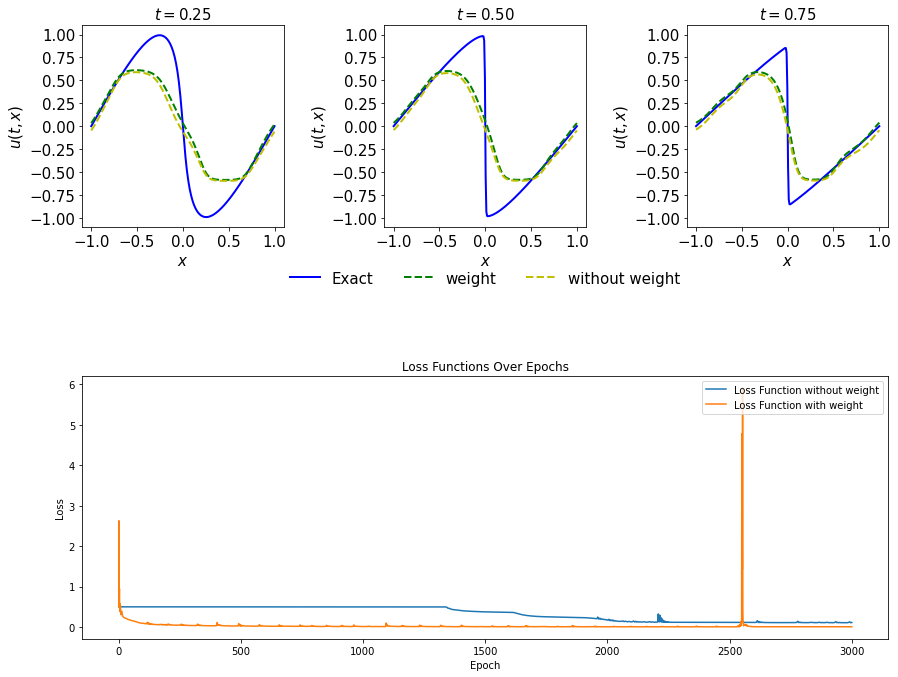

In [11]:
import scipy
import matplotlib.gridspec as gridspec

data = scipy.io.loadmat('/Users/jiangwengyao/Desktop/burgers_shock.mat')
Exact = np.real(data['usol']).T


def train(optimizer, epochs):
    lossList_weight = []
    lossList = []
    epochList_1 = []
    epochList_2 = []
    #pred_adam_1, pred_adam_2, pred_adam_3 = [], [], []
    pred_weight_1, pred_weight_2, pred_weight_3 = [], [], []
    pred_nn_1, pred_nn_2, pred_nn_3 = [], [], []


# with weight_adam
    for epoch in range(epochs):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_adam(adam_optimizer, spatial_coords, w)  # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step() 
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}, Loss Weights: {w.item()}, {1/w.item()}") 
        lossList_weight.append(loss_val.item())
        epochList_1.append(epoch)
        pred_weight_1.append(pred(nnt_1).detach().numpy())
        pred_weight_2.append(pred(nnt_2).detach().numpy())
        pred_weight_3.append(pred(nnt_3).detach().numpy())


# with weight_lbfgs    
    for epoch in range(epochs, epochs+1):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_lbfgs(lbfgs_optimizer, spatial_coords, w) # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}, Loss Weights: {w.item()}, {1/w.item()}") 
        
        lossList_weight.append(loss_val.item())
        epochList_1.append(epoch)  
        pred_weight_1.append(pred(nnt_1).detach().numpy())
        pred_weight_2.append(pred(nnt_2).detach().numpy())
        pred_weight_3.append(pred(nnt_3).detach().numpy())       


#   without weight
    for epoch in range(epochs+1):
        #total_loss = 0
        optimizer.zero_grad()
        loss_val = loss_function(spatial_coords)  # Calculate the loss
        loss_val.backward() # Backpropagation
        optimizer.step() 
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item()}") 
        lossList.append(loss_val.item())
        epochList_2.append(epoch)
        pred_nn_1.append(pred(nnt_1).detach().numpy())
        pred_nn_2.append(pred(nnt_2).detach().numpy())
        pred_nn_3.append(pred(nnt_3).detach().numpy())      

    
    #pred_grid = uNN.view(100, 100).numpy()

    fig = plt.figure(figsize=(14, 16))
    ax = fig.add_subplot(111)
    
    ax_t = np.linspace(0, 1, 256)
    ax_x = np.linspace(-1, 1, 256)

    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(ax_x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    # ax.plot(ax_x, pred_adam_1[0][:,0], 'r--', linewidth = 2, label = 'weight_adam')
    ax.plot(ax_x,pred_nn_1[epochs][:,0], 'g--', linewidth = 2, label = 'weight')
    ax.plot(ax_x, pred_nn_1[epochs-100][:,0], 'y--', linewidth = 2, label = 'without weight')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 15)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])


    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)


    ax = plt.subplot(gs1[0, 1])
    ax.plot(ax_x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    # ax.plot(ax_x,pred_adam_2[0][:,0], 'r--', linewidth = 2, label = 'weight_adam')
    ax.plot(ax_x,pred_nn_2[epochs][:,0], 'g--', linewidth = 2, label = 'weight')
    ax.plot(ax_x, pred_nn_2[epochs-100][:,0], 'y--', linewidth = 2, label = 'without weight')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 15)
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.15), 
        ncol=5, 
        frameon=False, 
        prop={'size': 15}
    )

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(ax_x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    # ax.plot(ax_x,pred_adam_3[0][:,0], 'r--', linewidth = 2, label = 'weight_adam')
    ax.plot(ax_x,pred_nn_3[epochs][:,0], 'g--', linewidth = 2, label = 'weight')
    ax.plot(ax_x, pred_nn_3[epochs-100][:,0], 'y--', linewidth = 2, label = 'without weight')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 15)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)


    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(top=1-2.0/3.0-0.1, bottom=0.005, left=0.1, right=0.9, hspace=0.5)

    ax_loss = plt.subplot(gs2[0, 0])
    ax_loss.plot(epochList_2, lossList, label='Loss Function without weight')
    ax_loss.plot(epochList_1, lossList_weight, label='Loss Function with weight')


    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Loss Functions Over Epochs') 
    ax_loss.legend(loc='upper right')
      
    
    plt.savefig('loss.png')
    #plt.tight_layout()
    plt.show()
    

# Train the neural network
train(adam, 3000)